In [2]:
import numpy as np
from threeflavorALLvalues import allSigmas
from scipy.integrate import odeint
from solveTmu import blackness
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import brentq, fsolve


import matplotlib.pyplot as plt


In [3]:
"Matching Fang paper"
v4=4.2
v3= -22.6/(6*np.sqrt(2))

def chiral(u,y,params):
    chi,chip=y
    v3,v4,lambda1,mu_g,a0,zh,q=params
    
    Q=q*zh**3
    
    
    "Ballon-Bayona version"
    phi = (mu_g*zh*u)**2-a0*(mu_g*zh*u)**3/(1+(mu_g*zh*u)**4)
    phip = 2*u*(zh*mu_g)**2+a0*(4*u**6*(zh*mu_g)**7/(1+(u*zh*mu_g)**4)**2-3*u**2*(zh*mu_g)**3/(1+(u*zh*mu_g)**4))

    f= 1 - (1+Q**2)*u**4 + Q**2*u**6
    fp= -4*(1+Q**2)*u**3 + 6*Q**2*u**5
    "EOM for chiral field"
    derivs=[chip,
            (3/u-fp/f+phip)*chip - (3*chi+lambda1*phi*chi-3*v3*chi**2-4*v4*chi**3)/(u**2*f)]
            #((3+u**4)/(u-u**5) +phip)*chip - (-3*chi+4*v4*chi**3)/(u**2-u**6) ]
            
    return derivs

def chiral_solve_IR(d0,lambda1,T,mu,ui,uf):
    u=np.linspace(ui,uf,1000)
    u_backward=np.linspace(uf,ui,1000)


    zeta=np.sqrt(3)/(2*np.pi)

    mu_g=440
    a0=0

    lambda3=v3
    lambda4=v4


    zh,q = blackness(T,mu)
    Q=q*zh**3

    d1 = (3 * d0 - 3 * d0**2 * lambda3 - 4 * d0**3 * lambda4 + d0 * zh**2 * lambda1 * mu_g**2) / (2 * (-2 + Q**2))


    "IR boundary condition"
    chi0=d0+d1*(1-uf)
    chip0=d1
    y0=[chi0,chip0]




    params=v3,v4,lambda1,mu_g,a0,zh,q
    
    "solve the EOM using solve_ivp"
    sol = solve_ivp(chiral, [uf, ui], y0, t_eval=u_backward, args=(params,))

    #sol=odeint(chiral,y0,u,args=(params,))
    #plot
    chi=sol.y[0][::-1]
    chip=sol.y[1][::-1]
 

    mq=chip[0]/(zeta*zh)


    return mq,chi,chip,u

def sigma_finder(u_intermediate,chi,u,mq,T,mu,zeta,lambda3):
    zh,q = blackness(T,mu)

    "find sigma"
    chi_interp=interp1d(u,chi)
    sigma=(chi_interp(u_intermediate)-mq*zeta*zh*u_intermediate+3*mq**2*zeta**2*lambda3*(zh*u_intermediate)**2)/(u_intermediate*zh)**3*zeta
    return sigma

def chiral_solve_UV(ml,sigmal,T,mu,ui,uf,lambda1):
    u=np.linspace(ui,uf,1000)
    zh,q = blackness(T,mu)
    zeta=np.sqrt(3)/(2*np.pi)
    mu_g=440
    a0=0

    lambda3=v3
    lambda4=v4

    params=v3,v4,lambda1,mu_g,a0,zh,q
    s2=-3*(ml*zeta)**2*v3
    s3=-9*(zeta*ml)**3*v3**2 + 2*(zeta*ml)**3*v4 + ml*zeta*mu_g**2 - 1/2*ml*zeta*lambda1*mu_g**2

    "values for chiral field and derivative at UV boundary"
    UVbound = [ml*zeta*zh*ui + sigmal/zeta*(zh*ui)**3+s2*(zh*ui)**2+s3*(zh*ui)**3*np.log(zh*ui), 
                ml*zeta*zh + 3*sigmal/zeta*zh**3*ui**2 + 2*s2*zh**2*ui + s3* ui**2*zh**3*(1+3*np.log(zh*ui))]
    "solve the EOM using solve_ivp"
    sol = solve_ivp(chiral, [ui, uf], UVbound, t_eval=u, args=(params,))

    chi=sol.y[0]
    chip=sol.y[1]
    return chi,chip,u
from joblib import Parallel, delayed

def chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(chiral_solve_IR)(d0, lambda1, T, mu, ui, uf) for d0 in d0_array
    )
    # Unpack the results
    mq_array, chi_array, chip_array, u_array = zip(*results)
    
    return np.array(mq_array)

In [72]:
def find_d0_hard_way(T,mu,lambda1,ui,uf,mq_target,d0_lower,d0_upper):
    
    d0_array=np.linspace(d0_lower,d0_upper,100)
    mq_array=chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)

    max_d0=d0_upper
    # find the indices where abs(mq_array)>150, and remove those indices from d0_array and mq_array
    indices=np.where(np.abs(mq_array)>150)
    # we don't need to go higher than the lowest d0 value that gives garbage results
    # if indices is not an empty array
    if len(indices[0])>0:
        max_d0=d0_array[indices[0]]
    if len(indices[0])>1:
        max_d0=max_d0[0]

    d0_array=np.delete(d0_array,indices)
    mq_array=np.delete(mq_array,indices)

    iterations=0
    step_size=d0_array[1]-d0_array[0]
    while mq_array[-1]<mq_target and iterations<20:
    #while max(mq_array)<mq_target and iterations<12:

        #create a new d0_array starting above the maximum value of d0_array, with a spacing that is 1/10 of the spacing of the previous d0_array
        step_size=step_size/10
        d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),((d0_array[1]-d0_array[0])/100))
        # d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),step_size)
        d0_array=np.concatenate((d0_array,d0_new))
        #calculate the mq_array for the new d0_array
        mq_new=chiral_solve_IR_parallel(d0_new, lambda1, T, mu, ui, uf, n_jobs=-1)
        #add the new mq_array to the old mq_array
        mq_array=np.concatenate((mq_array,mq_new))
        indices=np.where(np.abs(mq_array)>1000)
        # we don't need to go higher than the lowest d0 value that gives garbage results
        # if indices is not an empty array
        if len(indices[0])>0:
            max_d0=d0_array[indices[0]]
        if len(indices[0])>1:
            max_d0=max_d0[0]    
        d0_array=np.delete(d0_array,indices)
        mq_array=np.delete(mq_array,indices)
        # print(max_d0)
        old_max_d0=max_d0
        iterations=iterations+1
    buffer=1
    #find all the indices where mq_array-mq_target changes sign
    change_indices=np.where(np.diff(np.sign(mq_array-mq_target)))
    if change_indices[0].size>0:
        index=change_indices[0][-1]
    else:
        index=change_indices[-1]

    #index=np.argmin(np.abs(mq_array-mq_target))
    upper_index=min(index+buffer,len(d0_array)-1)
    lower_index=max(index-buffer,0)
    d0_lower=d0_array[lower_index]
    mq_lower=mq_array[lower_index]
    d0_upper=d0_array[upper_index]
    mq_upper=mq_array[upper_index]
    #if the target value is not in the range, increase the buffer and try again
    while mq_target>max(mq_upper,mq_lower) and buffer<len(d0_array):
        buffer=buffer+1
        lower_index=max(index-buffer,0)
        upper_index=min(index+buffer,len(d0_array)-1)
        d0_lower=d0_array[lower_index]
        mq_lower=mq_array[lower_index]
        d0_upper=d0_array[upper_index]
        mq_upper=mq_array[upper_index]
    while mq_target<min(mq_upper,mq_lower) and buffer<len(d0_array):
        buffer=buffer+1
        lower_index=max(index-buffer,0)
        upper_index=min(index+buffer,len(d0_array)-1)
        d0_lower=d0_array[lower_index]
        mq_lower=mq_array[lower_index]
        d0_upper=d0_array[upper_index]
        mq_upper=mq_array[upper_index]
    mq_approx=mq_array[index]#(mq_lower+mq_upper)/2
    
    return d0_lower,d0_upper,mq_approx,mq_lower,mq_upper

In [100]:
#run this to get the initial range of mq vs d0
#mq target should be 50 MeV or some large number
def initial_d0_mq(T,mu,mq_target,lambda1,ui,uf,d0_lower,d0_upper):
    
    d0_array=np.linspace(d0_lower,d0_upper,1000)
    mq_array=chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)

    max_d0=d0_upper
    # find the indices where abs(mq_array)>150, and remove those indices from d0_array and mq_array
    indices=np.where(np.abs(mq_array)>150)
    # we don't need to go higher than the lowest d0 value that gives garbage results
    # if indices is not an empty array
    if len(indices[0])>0:
        max_d0=d0_array[indices[0]]
    if len(indices[0])>1:
        max_d0=max_d0[0]

    d0_array=np.delete(d0_array,indices)
    mq_array=np.delete(mq_array,indices)

    iterations=0
    step_size=d0_array[1]-d0_array[0]
    while mq_array[-1]<mq_target and iterations<20:
    #while max(mq_array)<mq_target and iterations<12:

        #create a new d0_array starting above the maximum value of d0_array, with a spacing that is 1/10 of the spacing of the previous d0_array
        step_size=step_size/10
        d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),step_size)

        # d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),((d0_array[1]-d0_array[0])/100))
        # d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),step_size)
        d0_array=np.concatenate((d0_array,d0_new))
        #calculate the mq_array for the new d0_array
        mq_new=chiral_solve_IR_parallel(d0_new, lambda1, T, mu, ui, uf, n_jobs=-1)
        #add the new mq_array to the old mq_array
        mq_array=np.concatenate((mq_array,mq_new))
        indices=np.where(np.abs(mq_array)>1000)
        # we don't need to go higher than the lowest d0 value that gives garbage results
        # if indices is not an empty array
        if len(indices[0])>0:
            max_d0=d0_array[indices[0]]
        if len(indices[0])>1:
            max_d0=max_d0[0]    
        d0_array=np.delete(d0_array,indices)
        mq_array=np.delete(mq_array,indices)
        # print(max_d0)
        old_max_d0=max_d0
        iterations=iterations+1
    # print('iterations',iterations)
    return d0_array,mq_array

In [275]:
def d0_zoom(d0_lower,d0_upper,mq_target,T,mu,lambda1,ui,uf,tolerance_goal):
    precision=100
    iterations=0
    while precision>tolerance_goal and iterations<20:
        d0_array=np.linspace(d0_lower,d0_upper,100)
        mq_array=chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)
        #find the index where mq_array is closest to mq_target
        index=np.argmin(np.abs(mq_array-mq_target))
        #find the d0 value at that index
        d0_approx=d0_array[index]
        #find the mq value at that index
        mq_approx=mq_array[index]
        if abs(mq_target)>0:
            precision = np.abs(mq_approx-mq_target)/mq_target
        else:
            precision = np.abs(mq_approx-mq_target)
        d0_lower=d0_array[max(index-1,0)]
        d0_upper=d0_array[min(index+1,len(d0_array)-1)]
        iterations=iterations+1
        # print('iterations',iterations)
    return d0_approx,mq_approx


In [274]:
lambda1=5.6
T=85
zeta=np.sqrt(3)/(2*np.pi)
mu=0
mq=0
ui = 1e-4
uf = 1-ui
d0_lower=0
d0_upper=15
mq_large=50
d0_array,mq_array=initial_d0_mq(T,mu,mq_large,lambda1,ui,uf,d0_lower,d0_upper)


In [282]:


def all_sigmas_IR(lambda1,mq,T,mu,ui,uf,d0_lower,d0_upper,mq_large):
    tolerance_goal=1e-3
    zeta=np.sqrt(3)/(2*np.pi)
    d0_array,mq_array=initial_d0_mq(T,mu,mq_large,lambda1,ui,uf,d0_lower,d0_upper)
    #find the indices where mq_array-mq changes sign
    indices=np.where(np.diff(np.sign(mq_array-mq)))[0]
    d0_values=np.zeros(len(indices)) 
    mq_approx=np.zeros(len(indices))
    
    sigma_IR_list=np.zeros(len(indices))
    convergence_test=np.zeros(len(indices))
    # loop over the indices where mq_array-mq changes sign
    for i in range(len(indices)):
        d0_lower=d0_array[max(indices[i]-1,0)]
        d0_upper=d0_array[min(indices[i]+1,len(d0_array)-1)]
        # print("d0 range",d0_lower,d0_upper)
        d0_values[i],mq_approx[i]=d0_zoom(d0_lower,d0_upper,mq,T,mu,lambda1,ui,uf,tolerance_goal)
        if np.abs(mq)>0:
            if np.abs(mq_approx[i]-mq)/mq>tolerance_goal:
                print("Warning: tolerance not achieved for T=", T, " with quark mass=", mq_approx[i], " for the ", i+1 ,"th value of sigma")
                convergence_test[i]=1
        else:
            if np.abs(mq_approx[i]-mq)/mq>tolerance_goal:
                print("Warning: tolerance not achieved for T=", T, " with quark mass=", mq_approx[i], " for the ", i+1 ,"th value of sigma")
                convergence_test[i]=1
        # print(d0_values[i],mq_approx[i])
        #solve for chi and chi prime using chiral_solve_IR
        mq_approx[i],chi_IR,chip_IR,u=chiral_solve_IR(d0_values[i],lambda1,T,mu,ui,uf)
        #solve for sigma using sigma_finder
        u_intermediate=0.15
        sigma=sigma_finder(u_intermediate,chi_IR,u,mq,T,mu,zeta,v3)
        #store sigma in sigma_IR_list
        sigma_IR_list[i]=sigma
    

    return sigma_IR_list, convergence_test,d0_values, mq_approx

In [267]:
#define input parameters
lambda1=5.6
T=200

mu=0
#quark mass
mq=0
ui = 1e-4
uf = 1-ui
#range for d0 initial scan
d0_lower=0
d0_upper=15
# This should be larger than the target mq value
mq_large=50
# sigma_IR_list, d0_values, mq_approx=all_sigmas_IR(lambda1,mq,T,mu,ui,uf,d0_lower,d0_upper,mq_large)

In [283]:
temps=np.arange(15,110,5)
sigma_list=[]
convergence_list=[]
sigmas_array=np.zeros((len(temps),3))
for i in range(len(temps)):
    sigmas,convergence,d0s,mqs=all_sigmas_IR(lambda1,mq,temps[i],mu,ui,uf,d0_lower,d0_upper,mq_large)
    #if sigmas has less than 3 values, append 0's to sigmas until it has 3 values
    # if len(sigmas)<3:
    #     sigmas=np.append(sigmas,np.zeros(3-len(sigmas)))
    # print(sigmas)
    # sigmas_array[i,:]=sigmas
    #append sigmas to sigma_list
    sigma_list.append(sigmas)
    convergence_list.append(convergence)


/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_41989/1643550212.py:23: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs(mq_approx[i]-mq)/mq>tolerance_goal:
/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_41989/1643550212.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  if np.abs(mq_approx[i]-mq)/mq>tolerance_goal:


In [284]:
#find the length of the longest element in sigma_list
max_length=max(len(l) for l in sigma_list)
print(max_length)
#append 0's to the end of each element in sigma_list until it has length max_length
for i in range(len(sigma_list)):
    sigma_list[i]=np.append(sigma_list[i],np.zeros(max_length-len(sigma_list[i])))
    # also append 0's to the end of each element in convergence_list
    convergence_list[i]=np.append(convergence_list[i],np.zeros(max_length-len(convergence_list[i])))

#convert sigma_list to an array
sigmas_array=np.array(sigma_list)
convergence_array=np.array(convergence_list)
# print(sigmas_array.shape)


3


In [271]:
from criticalZoom import order_checker
minsigma=0
maxsigma=max(sigmas_array[:,0])**(1/3)+50
ml=mq
tmin=temps[0]
tmax=temps[-1]
numtemp=len(temps)
a0=0
tmin,tmax,minsigma,maxsigma,order,temps1,truesigma,Tc=order_checker(tmin,tmax,numtemp,minsigma,maxsigma,ml,mu,lambda1,a0)

get_all_sigmas_parallel took 1.438sec
Crossover or 2nd order
Pseudo-Critical temperature is between 80.0 100.0


/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/Documents/GitHub/DilatonMixingParallel/criticalZoom.py:166: RuntimeWarning: overflow encountered in power
  test = ((-u**2*fp)/f)*chiFields[:,1]-1/f*(3*chiFields[:,0]+lambda1*phi*chiFields[:,0]-3*v3*chiFields[:,0]**2-4*v4*chiFields[:,0]**3)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


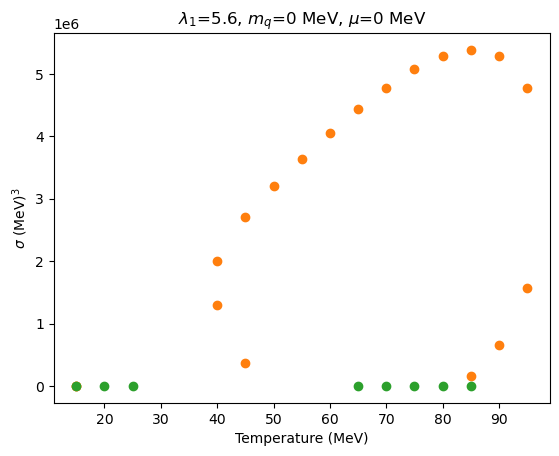

In [285]:
#get the color sequence for matplotlib
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i in range(max_length):
    #plot only the points where sigmas_array is nonzero

    # plot only the points where sigmas_array is nonzero and convergence_array is 0
    # this means that a real sigma value was found, and the solution for mq converged
    plt.scatter(temps[np.where((sigmas_array[:,i]!=0) & (convergence_array[:,i]==0))],sigmas_array[:,i][np.where((sigmas_array[:,i]!=0) & (convergence_array[:,i]==0))],color=colors[0])
    # plot only the points where sigmas_array is nonzero and convergence_array is 1
    # this means that a real sigma value was found, but the solution for mq did not converge
    plt.scatter(temps[np.where(convergence_array[:,i]==1)],sigmas_array[:,i][np.where(convergence_array[:,i]==1)],color=colors[1])



for i in range(len(truesigma[0])):
    #plot only the points where  truesigma is nonzero
    plt.scatter(temps[np.where(truesigma[:,i]!=0)],(truesigma[:,i][np.where(truesigma[:,i]!=0)])**3,color=colors[2])


# plt.legend()
plt.xlabel('Temperature (MeV)')
plt.ylabel('$\sigma$ (MeV)$^3$')
# title the plot with the value of lambda1, and the quark mass, and the value of mu
plt.title('$\lambda_1$='+str(lambda1)+', $m_q$='+str(mq)+' MeV'+', $\mu$='+str(mu)+' MeV')
plt.show()


In [236]:
temps=np.arange(39,42,0.05)
sigma_list=[]
convergence_list=[]
sigmas_array=np.zeros((len(temps),3))
for i in range(len(temps)):
    sigmas,convergence,d0s,mqs=all_sigmas_IR(lambda1,mq,temps[i],mu,ui,uf,d0_lower,d0_upper,mq_large)
    #if sigmas has less than 3 values, append 0's to sigmas until it has 3 values
    # if len(sigmas)<3:
    #     sigmas=np.append(sigmas,np.zeros(3-len(sigmas)))
    # print(sigmas)
    # sigmas_array[i,:]=sigmas
    #append sigmas to sigma_list
    sigma_list.append(sigmas)
    convergence_list.append(convergence)

In [237]:
#find the length of the longest element in sigma_list
max_length=max(len(l) for l in sigma_list)
# print(max_length)
#append 0's to the end of each element in sigma_list until it has length max_length
for i in range(len(sigma_list)):
    sigma_list[i]=np.append(sigma_list[i],np.zeros(max_length-len(sigma_list[i])))
    # also append 0's to the end of each element in convergence_list
    convergence_list[i]=np.append(convergence_list[i],np.zeros(max_length-len(convergence_list[i])))

#convert sigma_list to an array
sigmas_array=np.array(sigma_list)
convergence_array=np.array(convergence_list)
# print(sigmas_array.shape)

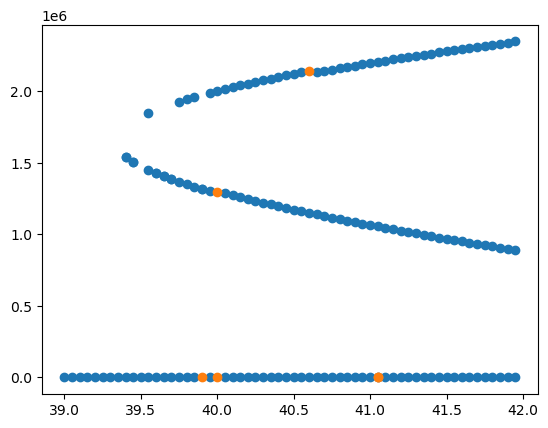

In [238]:
for i in range(max_length):
    #plot only the points where sigmas_array is nonzero

    # plot only the points where sigmas_array is nonzero and convergence_array is 0
    # this means that a real sigma value was found, and the solution for mq converged
    plt.scatter(temps[np.where((sigmas_array[:,i]!=0) & (convergence_array[:,i]==0))],sigmas_array[:,i][np.where((sigmas_array[:,i]!=0) & (convergence_array[:,i]==0))],color=colors[0])
    # plot only the points where sigmas_array is nonzero and convergence_array is 1
    # this means that a real sigma value was found, but the solution for mq did not converge
    plt.scatter(temps[np.where(convergence_array[:,i]==1)],sigmas_array[:,i][np.where(convergence_array[:,i]==1)],color=colors[1])

In [239]:
temps2=temps
sigmas_array2=sigmas_array

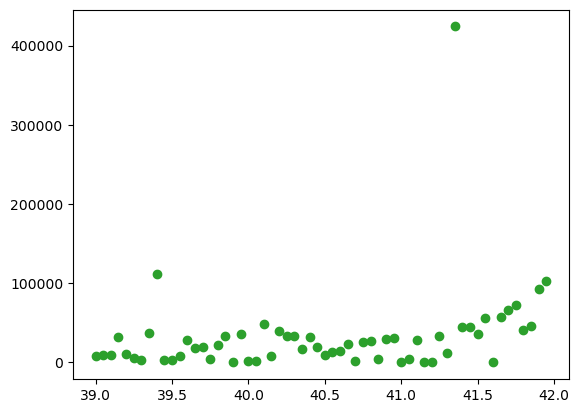

In [251]:
plt.scatter(temps2,sigmas_array2[:,0]**3,color=colors[2])